In [1]:
import torch
import numpy as np
import pandas as pd
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import os
from mpl_toolkits.mplot3d import Axes3D
import re

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score, mutual_info_score, classification_report, confusion_matrix, silhouette_score, accuracy_score
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.datasets import load_digits
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit, GridSearchCV
from scipy.interpolate import griddata

from sklearn.ensemble import RandomForestClassifier

from tqdm import tqdm

import glob


In [3]:
# start_sample = 4000
# start_sample = 3500
# start_sample = 3000
# start_sample = 2500
# start_sample = 2000
# start_sample = 1500
# start_sample = 1000
# start_sample = 750
# start_sample = 500
start_sample = 250

In [2]:
folder_mapping = {
    4000: "1_pre4k/",
    3500: "1_pre3k5/",
    3000: "1_pre3k/",
    2500: "1_pre2k5/",
    2000: "1_pre2k/",
    1500: "1_pre1k5/",
    1000: "1_pre1k/",
    750: "1_pre750/",
    500: "1_pre500/",
    250: "1_pre250/",
    # 250: "1_post250/"
}

folder_name = folder_mapping.get(start_sample)
data_dir = "./data/"+folder_name
result_dir = "./data/3_results_1/"
print(data_dir)
print(result_dir)

NameError: name 'start_sample' is not defined

# 1 Single Data Playground

### 1.1 Directory and names

In [19]:
file_name_1 = f"-{start_sample}-{start_sample+1250}_file_1_spk.pt"
file_name_2 = f"-{start_sample}-{start_sample+1250}_file_2_spk.pt" 
file_name_3 = f"-{start_sample}-{start_sample+1250}_file_3_spk.pt"
print(f"Reading from {file_name_1}, {file_name_2}, and {file_name_3}")
data_1 = torch.load(data_dir + file_name_1)
data_2 = torch.load(data_dir + file_name_2)
data_3 = torch.load(data_dir + file_name_3)
data_all = torch.cat([data_1, data_2, data_3], dim=0)
print(data_all.shape)
print("Finished.")

Reading from -250-1500_file_1_spk.pt, -250-1500_file_2_spk.pt, and -250-1500_file_3_spk.pt
torch.Size([3459, 76])
Finished.


C:\Users\askrb\AppData\Local\Temp\ipykernel_61588\3663485743.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data_1 = torch.load(data_dir + file_name_1)
C:\Users\askrb\A

### 1.2 Remove last label

In [20]:
# Split data_all into features (X) and labels (y)
X = data_all[:, :-1]  # All columns except last
y = data_all[:, -1]   # Last column

# Remove samples with label 8
mask = y != 8
X = X[mask]
y = y[mask]

In [21]:
X.shape

torch.Size([3454, 75])

In [23]:
y.shape

torch.Size([3454])

### 1.3 SVM

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# svm_model = SVC(kernel='linear')
svm_model = SVC(kernel='rbf')

param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [0.001, 0.01, 0.1, 1, 'scale', 'auto'],
}
grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

y_pred = grid_search.predict(X_test)
print(classification_report(y_test, y_pred))

Best parameters found:  {'C': 10, 'gamma': 'scale'}
Best cross-validation score: 0.48
              precision    recall  f1-score   support

         2.0       0.46      0.44      0.45       157
         3.0       0.44      0.46      0.45       204
         4.0       0.51      0.55      0.53       185
         5.0       0.56      0.55      0.56       193
         6.0       0.38      0.39      0.38       154
         7.0       0.52      0.45      0.48       144

    accuracy                           0.48      1037
   macro avg       0.48      0.47      0.48      1037
weighted avg       0.48      0.48      0.48      1037



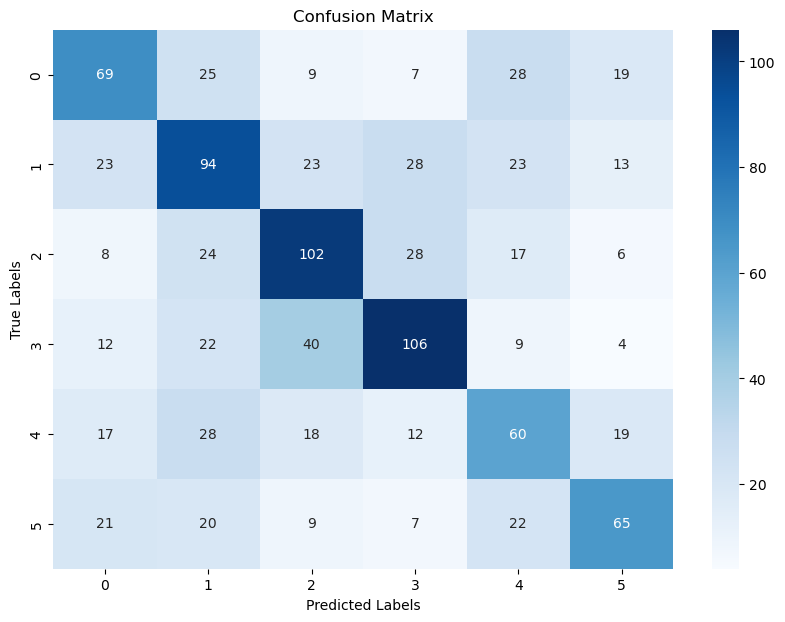

In [25]:
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# 2 Batch Processing

### 2.1 RBF (Done)

In [3]:
def process_dataset(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # SVM
    svm_model = SVC()
    param_grid = {
        'kernel': ['rbf'],
        # 'kernel': ['linear', 'rbf'],
        'C': [0.1, 1, 10, 100, 1000],
        'gamma': [0.001, 0.01, 0.1, 1, 'scale', 'auto']
    }

    grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    y_pred = grid_search.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)

    results = {
        'kernel': best_params['kernel'],
        'C': best_params['C'],
        'gamma': best_params.get('gamma', 'N/A'), # N/A for linear kernel
        'CV_Score': best_score,
        'Accuracy': test_accuracy
    }

    return results

In [10]:
# Define folders to process
folders = {
    4000: "1_pre4k/",
    3500: "1_pre3k5/", 
    3000: "1_pre3k/",
    2500: "1_pre2k5/",
    2000: "1_pre2k/",
    1500: "1_pre1k5/",
    1000: "1_pre1k/",
    750: "1_pre750/",
    500: "1_pre500/",
    250: "1_pre250/"
}

for start_sample, folder in tqdm(folders.items(), desc="Processing datasets"):
    print(f"\nProcessing folder: {folder}")
    data_dir = f"./data/{folder}"
    result_dir = "./data/3_batch_ml_results_rbf"
    os.makedirs(result_dir, exist_ok=True)
    
    # Get list of all data files in directory
    data_files = glob.glob(os.path.join(data_dir, "*_spk.pt"))

    # Group files by their time window
    file_groups = {}
    for file in data_files:
        # Extract time window from filename
        match = re.search(r'250-(\d+)_file', file)  # Updated regex pattern to match 250-100_file_1_spk.pt format
        if match:
            end = match.group(1)
            key = f"250-{end}"
            if key not in file_groups:
                file_groups[key] = []
            file_groups[key].append(file)

    print(f"Found {len(file_groups)} start-end pairs")

    # Verify each group has 3 files
    invalid_groups = []
    for window, files in file_groups.items():
        if len(files) != 3:
            invalid_groups.append(window)
            print(f"Error: Window {window} has {len(files)} files instead of 3")
    
    if invalid_groups:
        raise ValueError(f"The following windows do not have exactly 3 files: {invalid_groups}")

    all_results = []

    # Process each time window group
    for window, files in file_groups.items():
        # Load and concatenate all files for this window
        data_list = []
        for file in files:
            data = torch.load(file, weights_only=True)
            data_list.append(data)
        data_all = torch.cat(data_list, dim=0)
        
        # Remove label 8
        mask = data_all[:,-1] != 8.0
        data_filtered = data_all[mask]

        # Select features and labels
        X = data_filtered[:, :75]  # first 75 columns as features
        y = data_filtered[:, -1]   # last column as the label

        # Process
        result = process_dataset(X, y)
        start, end = window.split('-')  # Simplified since format is now always "250-end"
        result['start'] = int(start)
        result['end'] = int(end)
        all_results.append(result)

    
    # Save results for this folder
    results_df = pd.DataFrame(all_results)
    save_path = os.path.join(result_dir, f"results_-{start_sample}.csv")
    results_df.to_csv(save_path, index=False)
    print(f"Results saved to {save_path}")

Processing datasets:   0%|          | 0/1 [00:00<?, ?it/s]


Processing folder: 1_post250/
Found 18 start-end pairs


Processing datasets:   0%|          | 0/1 [01:04<?, ?it/s]


KeyboardInterrupt: 

In [11]:
# Define folders to process
folders = {
    250: "1_post250/"
}

for start_sample, folder in tqdm(folders.items(), desc="Processing datasets"):
    print(f"\nProcessing folder: {folder}")
    data_dir = f"./data/{folder}"
    result_dir = "./data/3_batch_ml_results_rbf"
    os.makedirs(result_dir, exist_ok=True)
    
    # Get list of all data files in directory
    data_files = glob.glob(os.path.join(data_dir, "*_spk.pt"))

    # Group files by their time window
    file_groups = {}
    for file in data_files:
        # Extract time window from filename
        match = re.search(r'250-(\d+)_file', file)  # Updated regex pattern to match 250-100_file_1_spk.pt format
        if match:
            end = match.group(1)
            key = f"250-{end}"
            if key not in file_groups:
                file_groups[key] = []
            file_groups[key].append(file)

    print(f"Found {len(file_groups)} start-end pairs")

    # Verify each group has 3 files
    invalid_groups = []
    for window, files in file_groups.items():
        if len(files) != 3:
            invalid_groups.append(window)
            print(f"Error: Window {window} has {len(files)} files instead of 3")
    
    if invalid_groups:
        raise ValueError(f"The following windows do not have exactly 3 files: {invalid_groups}")

    all_results = []

    # Process each time window group
    for window, files in file_groups.items():
        # Load and concatenate all files for this window
        data_list = []
        for file in files:
            data = torch.load(file, weights_only=True)
            data_list.append(data)
        data_all = torch.cat(data_list, dim=0)
        
        # Remove label 8
        mask = data_all[:,-1] != 8.0
        data_filtered = data_all[mask]

        # Select features and labels
        X = data_filtered[:, :75]  # first 75 columns as features
        y = data_filtered[:, -1]   # last column as the label

        # Process
        result = process_dataset(X, y)
        start, end = window.split('-')  # Simplified since format is now always "250-end"
        result['start'] = int(start)
        result['end'] = int(end)
        all_results.append(result)

    
    # Save results for this folder
    results_df = pd.DataFrame(all_results)
    save_path = os.path.join(result_dir, f"results_{start_sample}.csv")
    results_df.to_csv(save_path, index=False)
    print(f"Results saved to {save_path}")

Processing datasets:   0%|          | 0/1 [00:00<?, ?it/s]


Processing folder: 1_post250/
Found 18 start-end pairs


Processing datasets: 100%|██████████| 1/1 [03:03<00:00, 183.83s/it]

Results saved to ./data/3_batch_ml_results_rbf\results_250.csv


### 2.2 Linear

In [5]:
def process_dataset_linear(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # SVM
    svm_model = SVC()
    param_grid = {
        'kernel': ['linear'],
        'C': [0.1, 1, 10, 100, 1000],
    }

    grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    y_pred = grid_search.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)

    results = {
        'kernel': best_params['kernel'],
        'C': best_params['C'],
        'CV_Score': best_score,
        'Accuracy': test_accuracy
    }

    return results

In [6]:
# Define folders to process
folders = {
    4000: "1_pre4k/",
    3500: "1_pre3k5/", 
    3000: "1_pre3k/",
    2500: "1_pre2k5/",
    2000: "1_pre2k/",
    1500: "1_pre1k5/",
    1000: "1_pre1k/",
    750: "1_pre750/",
    500: "1_pre500/",
    250: "1_pre250/",
}

for start_sample, folder in tqdm(folders.items(), desc="Processing datasets"):
    print(f"\nProcessing folder: {folder}")
    data_dir = f"./data/{folder}"
    result_dir = "./data/3_batch_ml_results_linear"
    os.makedirs(result_dir, exist_ok=True)
    
    # Get list of all data files in directory
    data_files = glob.glob(os.path.join(data_dir, "*_spk.pt"))

    # Group files by their time window
    file_groups = {}
    for file in data_files:
        # Extract time window from filename
        match = re.search(r'-(\d+)-(\d+)_file', file)
        if match:
            start, end = match.groups()
            key = f"{start}-{end}"
            if key not in file_groups:
                file_groups[key] = []
            file_groups[key].append(file)

    print(f"Found {len(file_groups)} start-end pairs")

    # Verify each group has 3 files
    invalid_groups = []
    for window, files in file_groups.items():
        if len(files) != 3:
            invalid_groups.append(window)
            print(f"Error: Window {window} has {len(files)} files instead of 3")
    
    if invalid_groups:
        raise ValueError(f"The following windows do not have exactly 3 files: {invalid_groups}")

    all_results = []

    # Process each time window group
    for window, files in file_groups.items():
        # Load and concatenate all files for this window
        data_list = []
        for file in files:
            data = torch.load(file, weights_only=True)
            data_list.append(data)
        data_all = torch.cat(data_list, dim=0)
        
        # Remove label 8
        mask = data_all[:,-1] != 8.0
        data_filtered = data_all[mask]

        # Select features and labels
        X = data_filtered[:, :75]  # first 75 columns as features
        y = data_filtered[:, -1]   # last column as the label

        # Process
        result = process_dataset_linear(X, y)
        start, end = window.split('-')
        result['start'] = int(start)
        result['end'] = int(end)
        all_results.append(result)

Processing datasets:   0%|          | 0/11 [00:00<?, ?it/s]


Processing folder: 1_pre4k/
Found 80 start-end pairs


Processing datasets:   0%|          | 0/11 [3:53:18<?, ?it/s]


KeyboardInterrupt: 

# 3 Visualize the result from above

In [7]:
plot_dir = "./data/3_plots_2/"

In [93]:
# in the plot, alpha is between 0.2 and 1.0
# when the end is less than 4000, alpha is between 0.2 and 0.9
# 0.9-1 is reserved for the end which is larger than 4000
def get_alpha(row):
    if row['end'] <= 4000:
        return 0.2 + (row['end']/4000) * 0.7  # Scale between 0.2 and 0.9
    else:
        extra = (row['end'] - 4000) / 4000  # Calculate extra portion above 4000
        return 0.9 + (extra * 0.1)  # Scale between 0.9 and 1.0

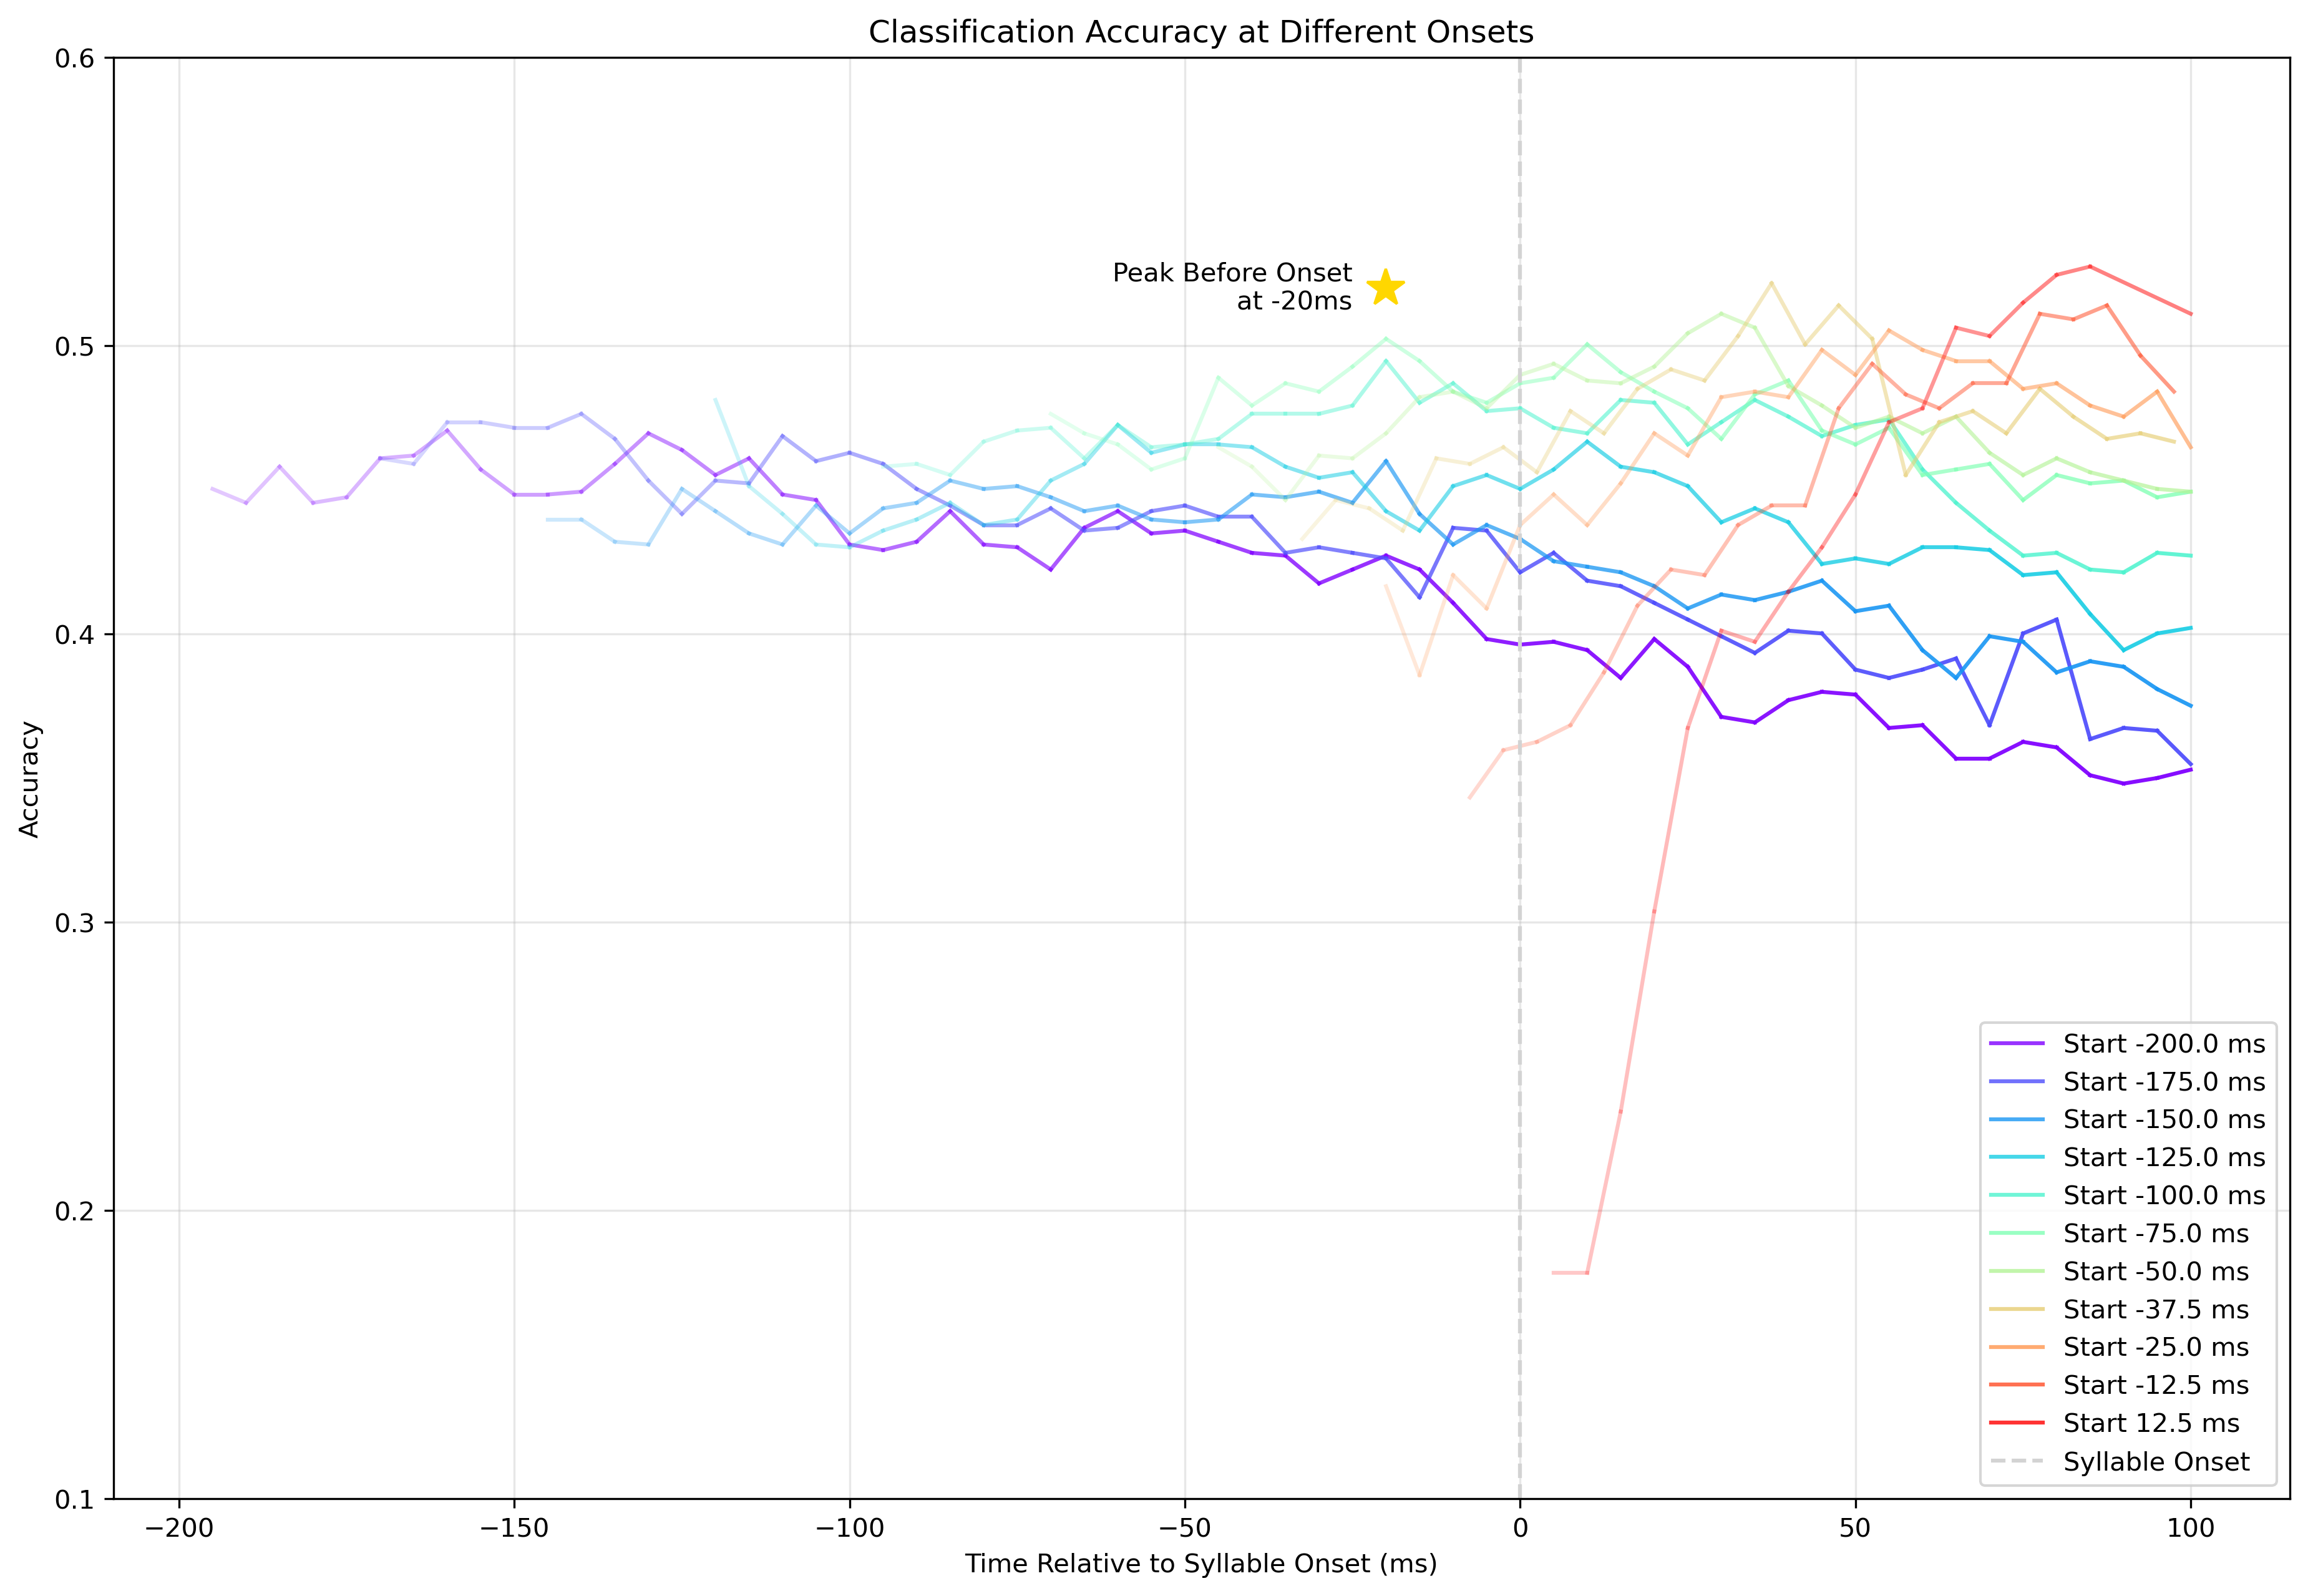

In [119]:
# Get all files from results directory
result_dir = "./data/3_batch_ml_results_rbf"
plot_dir = "./data/3_plots_2/"

if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

# Create single figure for all plots
plt.figure(figsize=(15, 10), dpi=300)

# Get all CSV files sorted by start time
csv_files = glob.glob(os.path.join(result_dir, "results_*.csv"))
csv_files.sort(key=lambda x: int(x.split('_')[-1].split('.')[0]))

# Create color map
colors = plt.cm.rainbow(np.linspace(0, 1, len(csv_files)))

for i, file_path in enumerate(csv_files):
    df = pd.read_csv(file_path)
    file_name = os.path.basename(file_path)
    
    # Extract start time from filename
    start = int(file_name.split('_')[1].split('.')[0])
    
    if 'end' in df.columns and 'Accuracy' in df.columns:
        # Filter out rows where end > 6000
        df = df[df['end'] <= 6000]
        
        # Skip if no data left after filtering
        if len(df) == 0:
            continue
            
        # Sort by end values
        df = df.sort_values('end')
        end = df['end']
        accuracy = df['Accuracy']
        
        # Calculate time points relative to stimulus onset
        if "-" in file_name:  # For negative start time (e.g. results_-250.csv)
            time_points = (end + start) / 20  # Add negative start to shift left and convert to ms
        else:  # For positive start time (e.g. results_250.csv)
            time_points = end / 20  # Keep original end times for positive start and convert to ms
            
                
        alphas = df.apply(get_alpha, axis=1)
        
        for j in range(len(time_points)-1):
            plt.plot(time_points.iloc[j:j+2], accuracy.iloc[j:j+2], 
                    color=colors[i], alpha=alphas.iloc[j])
            
        # Add solid color line to legend
        plt.plot([], [], color=colors[i], label=f'Start {start/20} ms', alpha=0.8)

plt.axvline(x=0, color='lightgray', linestyle='--', label='Syllable Onset', alpha=1)

# Add star marker at (-20, 0.51) with text annotation
plt.plot(-20, 0.52, marker='*', color='gold', markersize=15)
plt.annotate('Peak Before Onset\nat -20ms', 
            xy=(-20, 0.52), 
            xytext=(-25, 0.52),
            ha='right',
            va='center')
# Add light yellow line
# plt.axvline(x=-20, color='gold', alpha=0.5, linestyle='--')

plt.ylim(0.1, 0.6)
# plt.xlim(-200, 100)
plt.xlabel('Time Relative to Syllable Onset (ms)')
plt.ylabel('Accuracy')
plt.title('Classification Accuracy at Different Onsets')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

plt.savefig(os.path.join(plot_dir, 'accuracy_vs_time.pdf'), dpi=300, bbox_inches='tight')
plt.show()

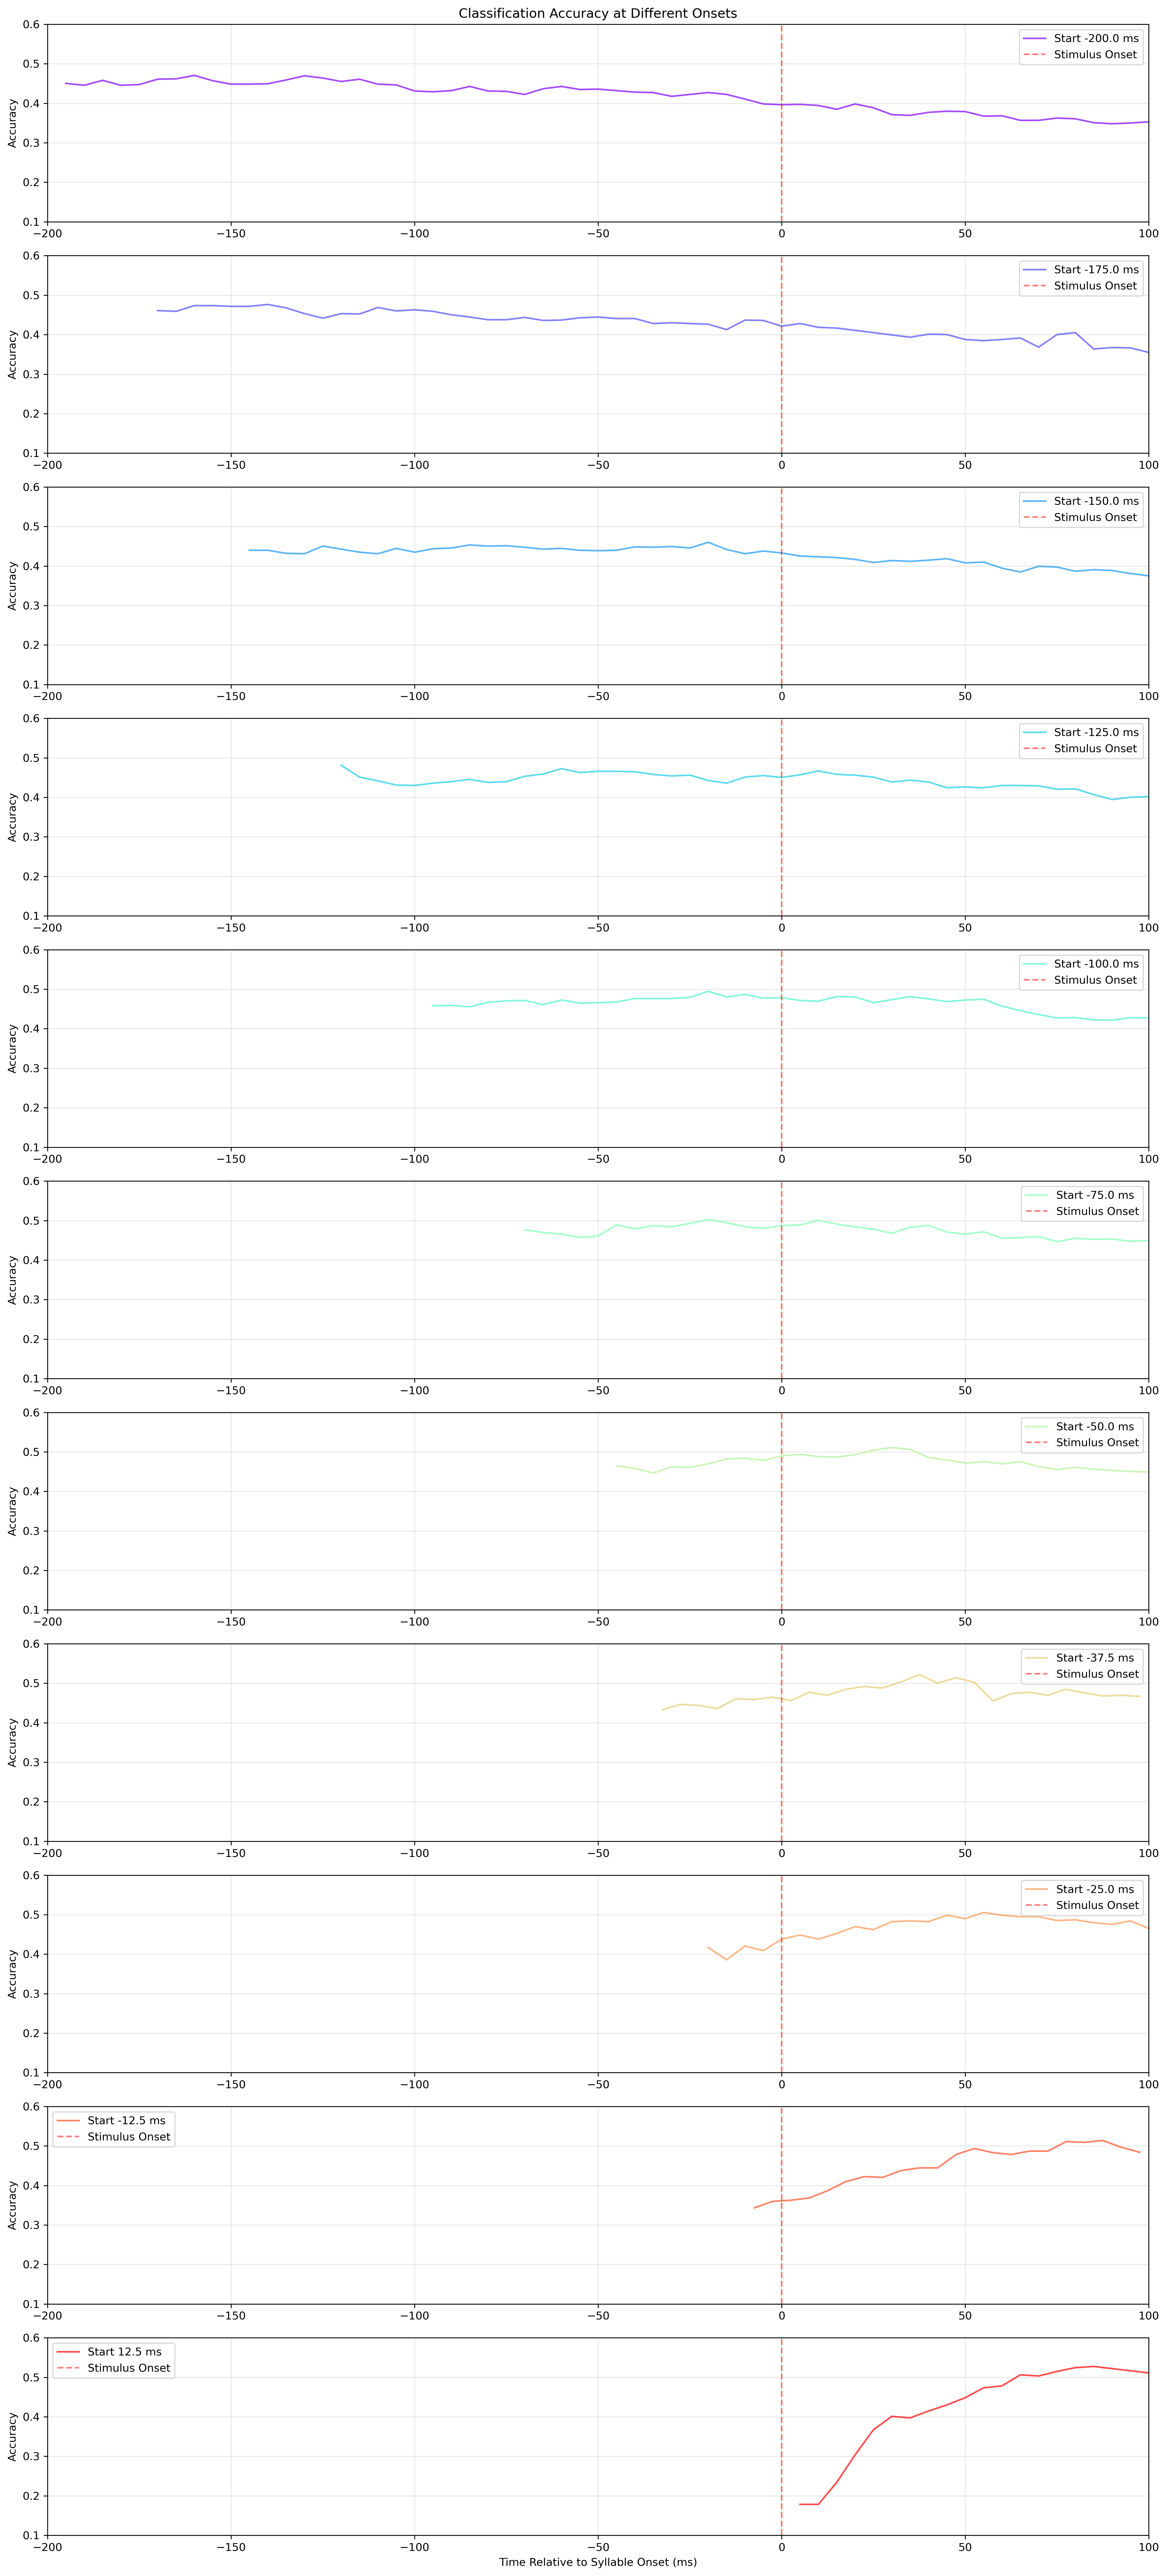

In [84]:
# Get all files 
result_dir = "./data/3_batch_ml_results_rbf"
plot_dir = "./data/3_plots_2/"

if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

# Get all CSV files sorted by start time
csv_files = glob.glob(os.path.join(result_dir, "results_*.csv"))
csv_files.sort(key=lambda x: int(x.split('_')[-1].split('.')[0]))

# Create color gradient using rainbow colormap
n_files = len(csv_files)
colors = plt.cm.rainbow(np.linspace(0, 1, n_files))

# Create figure with subplots
fig, axs = plt.subplots(n_files, 1, figsize=(15, 3*n_files), dpi=300)

for i, file_path in enumerate(csv_files):
    df = pd.read_csv(file_path)
    file_name = os.path.basename(file_path)
    
    # Extract start time from filename
    start = int(file_name.split('_')[1].split('.')[0])
    
    if 'end' in df.columns and 'Accuracy' in df.columns:
        # Sort by end values
        df = df.sort_values('end')
        end = df['end']
        accuracy = df['Accuracy']
        
        # Calculate time points relative to stimulus onset
        if "-" in file_name:  # For negative start time (e.g. results_-250.csv)
            time_points = (end + start) / 20  # Add negative start to shift left and convert to ms
        else:  # For positive start time (e.g. results_250.csv)
            time_points = end / 20  # Keep original end times for positive start and convert to ms
            
        axs[i].plot(time_points, accuracy, label=f'Start {start/20} ms', 
                    color=colors[i], alpha=0.7)

        axs[i].axvline(x=0, color='red', linestyle='--', label='Stimulus Onset', alpha=0.5)

        axs[i].set_ylim(0.1, 0.6)
        axs[i].set_xlim(-200, 100)
        if i == n_files-1:  # Only show x-label on bottom subplot
            axs[i].set_xlabel('Time Relative to Syllable Onset (ms)')
        axs[i].set_ylabel('Accuracy')
        if i == 0:  # Only show title on first subplot
            axs[i].set_title('Classification Accuracy at Different Onsets')
        else:
            axs[i].set_title('')
        axs[i].legend()
        axs[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(plot_dir, 'accuracy_all_onsets.pdf'), dpi=300, format='pdf')
plt.show()

# 4 Process on pre_moving_window

In [3]:
file_name_1 = f"-3000-1000_file_1_spk.csv"
file_name_2 = f"-3000-1000_file_2_spk.csv"
file_name_3 = f"-3000-1000_file_3_spk.csv"
print(f"Reading from {file_name_1}, {file_name_2}, and {file_name_3}")
data_dir = "drive/MyDrive/neuro2voc/task_2/data/1_pre_moving_window/"
data_1_df = pd.read_csv(data_dir + file_name_1)
data_2_df = pd.read_csv(data_dir + file_name_2)
data_3_df = pd.read_csv(data_dir + file_name_3)
data_all_df = pd.concat([data_1_df, data_2_df, data_3_df], ignore_index=True)
print("Finished.")

Reading from -3000-1000_file_1_spk.csv, -3000-1000_file_2_spk.csv, and -3000-1000_file_3_spk.csv
Finished.


In [4]:
data_all_df

,-3000--2600_N1,-3000--2600_N2,-3000--2600_N3,-3000--2600_N4,-3000--2600_N5,-3000--2600_N6,-3000--2600_N7,-3000--2600_N8,-3000--2600_N9,-3000--2600_N10,...,600-1000_N67,600-1000_N68,600-1000_N69,600-1000_N70,600-1000_N71,600-1000_N72,600-1000_N73,600-1000_N74,600-1000_N75,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,2.0,0.0,0.0,2.0,1.0,0.0,0.0,2.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3454,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,6.0
3455,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,7.0
3456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
3457,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,4.0


In [ ]:
data_filtered_df = data_all_df[data_all_df.iloc[:, -1] != 8.0]
data_filtered_df

,-3000--2600_N1,-3000--2600_N2,-3000--2600_N3,-3000--2600_N4,-3000--2600_N5,-3000--2600_N6,-3000--2600_N7,-3000--2600_N8,-3000--2600_N9,-3000--2600_N10,...,600-1000_N67,600-1000_N68,600-1000_N69,600-1000_N70,600-1000_N71,600-1000_N72,600-1000_N73,600-1000_N74,600-1000_N75,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,2.0,0.0,0.0,2.0,1.0,0.0,0.0,2.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3454,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,6.0
3455,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,7.0
3456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
3457,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,4.0


In [ ]:
X = data_filtered_df.iloc[:, :5475]  # first 5475 columns as features
y = data_filtered_df.iloc[:, -1]   # last column as the label

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:

svm_model = SVC()

param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [0.001, 0.01, 0.1, 1, 'scale', 'auto'],
    'kernel': ['rbf']
}
grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: {:.3f}".format(grid_search.best_score_))

y_pred = grid_search.predict(X_test)
print(classification_report(y_test, y_pred))

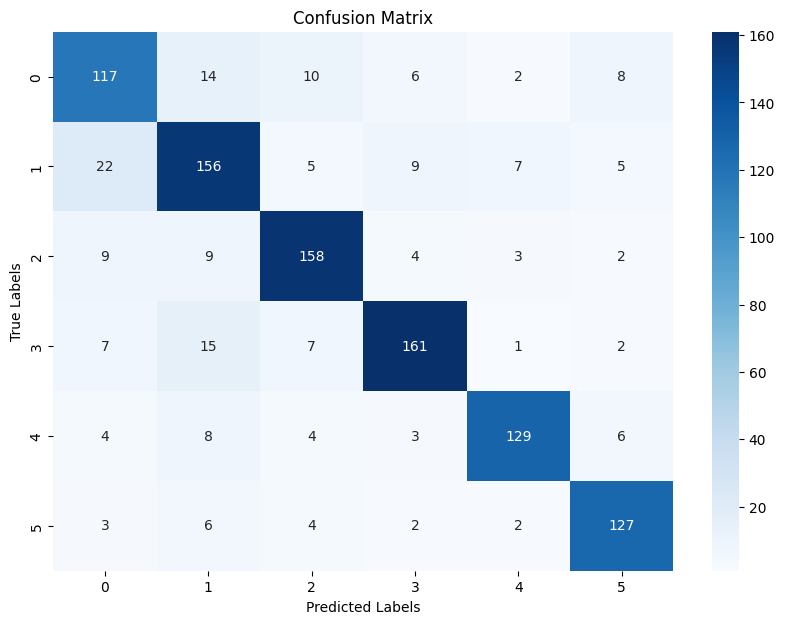

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
svm_model = SVC()

param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'kernel': ['linear']
}
grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

y_pred = grid_search.predict(X_test)
print(classification_report(y_test, y_pred))

Best parameters found:  {'C': 0.1, 'kernel': 'linear'}
Best cross-validation score: 0.80
              precision    recall  f1-score   support

         2.0       0.74      0.73      0.73       157
         3.0       0.67      0.75      0.71       204
         4.0       0.79      0.82      0.80       185
         5.0       0.85      0.80      0.82       193
         6.0       0.88      0.80      0.84       154
         7.0       0.86      0.86      0.86       144

    accuracy                           0.79      1037
   macro avg       0.80      0.79      0.79      1037
weighted avg       0.79      0.79      0.79      1037



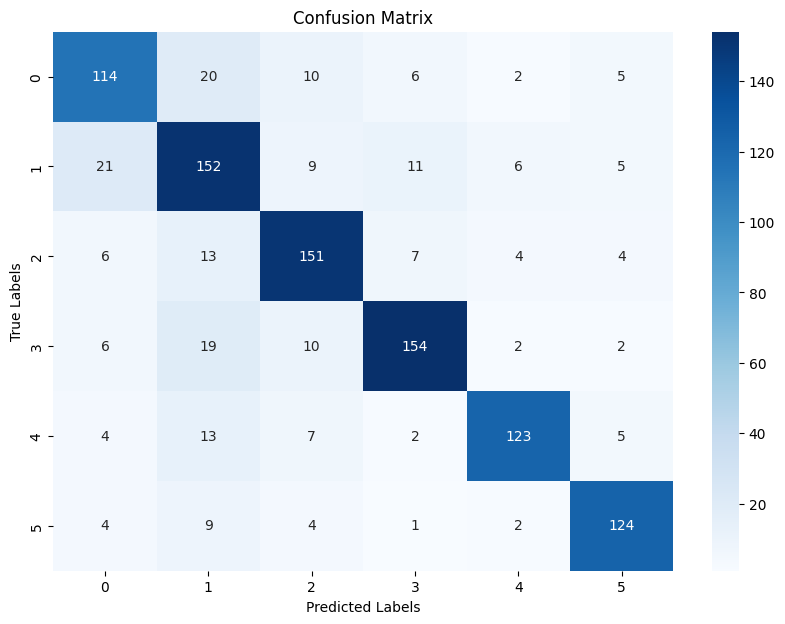

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Random Forest

In [ ]:
param_grid = {
    'n_estimators': [50, 100, 200, 300, 500]  # Different numbers of trees to try
}

rf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

grid_search.fit(X_train, y_train)

# Print the best parameters and the corresponding score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_}")

Best parameters: {'n_estimators': 500}
Best cross-validation score: 0.745956744178088


In [ ]:
rf = RandomForestClassifier(n_estimators=500, random_state=42)
rf.fit(X_train, y_train)
importances = rf.feature_importances_
feature_names = X_train.columns
feature_importances = pd.DataFrame(importances, index=feature_names, columns=["Importance"]).sort_values(by="Importance", ascending=False)

In [ ]:
accuracy = rf.score(X_test, y_test)
print(f"Accuracy of RandomForestClassifier: {accuracy:.2f}")

Accuracy of RandomForestClassifier: 0.74


In [ ]:
feature_importances

,Importance
600-1000_N31,0.002313
550-950_N31,0.002077
400-800_N31,0.002072
500-900_N31,0.002058
450-850_N31,0.002030
...,...
-1350--950_N14,0.000000
-1350--950_N15,0.000000
-1350--950_N16,0.000000
-1350--950_N17,0.000000


In [ ]:
feature_importances['x'] = feature_importances.index.to_series().apply(lambda name: int(name.split('_N')[0].split('-')[0]) if name[0] != '-' else int('-' + name.split('_N')[0].split('-')[1]))
feature_importances['neuron'] = feature_importances.index.to_series().apply(lambda name: int(name.split('_N')[1])-1) # beucase y in idx2depth range from 0 to 74 and here 1 to 75

print(feature_importances)

                Importance     x  neuron
600-1000_N31      0.002313   600      30
550-950_N31       0.002077   550      30
400-800_N31       0.002072   400      30
500-900_N31       0.002058   500      30
450-850_N31       0.002030   450      30
...                    ...   ...     ...
-1350--950_N14    0.000000 -1350      13
-1350--950_N15    0.000000 -1350      14
-1350--950_N16    0.000000 -1350      15
-1350--950_N17    0.000000 -1350      16
600-1000_N75      0.000000   600      74

[5475 rows x 3 columns]


In [ ]:
import json

with open('drive/MyDrive/neuro2voc/task_2/data/0_raw/idx2depth.json', 'r') as json_file:
    idx2depth = json.load(json_file)

In [ ]:
idx2depth

{'0': 660,
 '1': 1320,
 '2': 1320,
 '3': 1340,
 '4': 1680,
 '5': 1820,
 '6': 2140,
 '7': 2220,
 '8': 2240,
 '9': 2260,
 '10': 2280,
 '11': 2300,
 '12': 2320,
 '13': 2340,
 '14': 2380,
 '15': 2360,
 '16': 2400,
 '17': 2420,
 '18': 2440,
 '19': 2440,
 '20': 2460,
 '21': 2480,
 '22': 2480,
 '23': 2500,
 '24': 2520,
 '25': 2520,
 '26': 2540,
 '27': 2540,
 '28': 2580,
 '29': 2580,
 '30': 2580,
 '31': 2600,
 '32': 2600,
 '33': 2600,
 '34': 2600,
 '35': 2640,
 '36': 2640,
 '37': 2660,
 '38': 2680,
 '39': 2720,
 '40': 2880,
 '41': 2960,
 '42': 3200,
 '43': 2380,
 '44': 2560,
 '45': 2640,
 '46': 2660,
 '47': 2720,
 '48': 2740,
 '49': 2580,
 '50': 2580,
 '51': 2460,
 '52': 2680,
 '53': 840,
 '54': 480,
 '55': 480,
 '56': 2860,
 '57': 200,
 '58': 3220,
 '59': 3180,
 '60': 2980,
 '61': 1060,
 '62': 1120,
 '63': 1060,
 '64': 1080,
 '65': 1680,
 '66': 1880,
 '67': 2100,
 '68': 2160,
 '69': 2180,
 '70': 2280,
 '71': 2360,
 '72': 2700,
 '73': 2820,
 '74': 3380}

In [ ]:
idx2depth_int_keys = {int(k): v for k, v in idx2depth.items()}
feature_importances['y'] = feature_importances['neuron'].map(idx2depth_int_keys)
feature_importances

,Importance,x,neuron,y
600-1000_N31,0.002313,600,30,2580
550-950_N31,0.002077,550,30,2580
400-800_N31,0.002072,400,30,2580
500-900_N31,0.002058,500,30,2580
450-850_N31,0.002030,450,30,2580
...,...,...,...,...
-1350--950_N14,0.000000,-1350,13,2340
-1350--950_N15,0.000000,-1350,14,2380
-1350--950_N16,0.000000,-1350,15,2360
-1350--950_N17,0.000000,-1350,16,2400


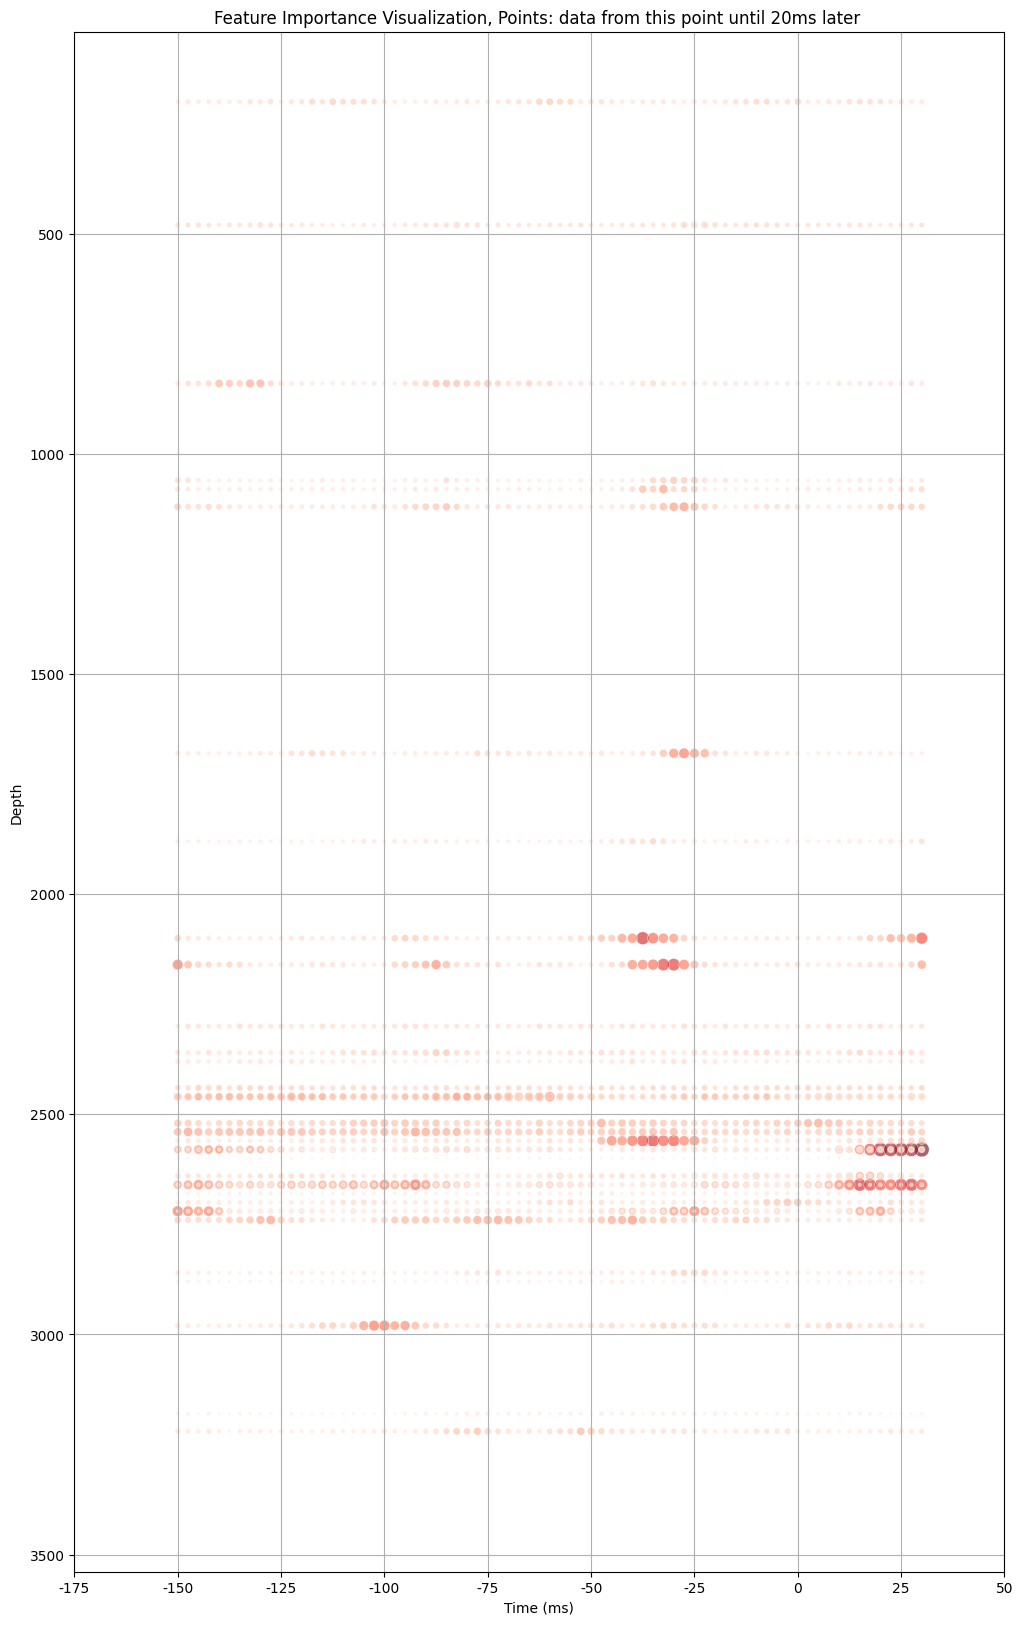

In [ ]:
norm = mcolors.Normalize(vmin=feature_importances['Importance'].min(), vmax=feature_importances['Importance'].max())
sizes = feature_importances['Importance'] * 50000  # Scale sizes for better visibility

# Plotting
plt.figure(figsize=(12, 20))
plt.scatter(feature_importances['x'], feature_importances['y'], s=sizes, c=feature_importances['Importance'], cmap='Reds', alpha=0.6, edgecolors="w", linewidth=0.5)
# plt.colorbar(label='Feature Importance')
plt.xlabel('Time (ms)')
plt.ylabel('Depth')
plt.gca().invert_yaxis()  # Invert y-axis to have smallest depth on top
plt.title('Feature Importance Visualization, Points: data from this point until 20ms later ')
plt.grid(True)


xticks = plt.gca().get_xticks()
plt.gca().set_xticks(xticks)
plt.gca().set_xticklabels([f'{int(x/20)}' for x in xticks])

plt.show()

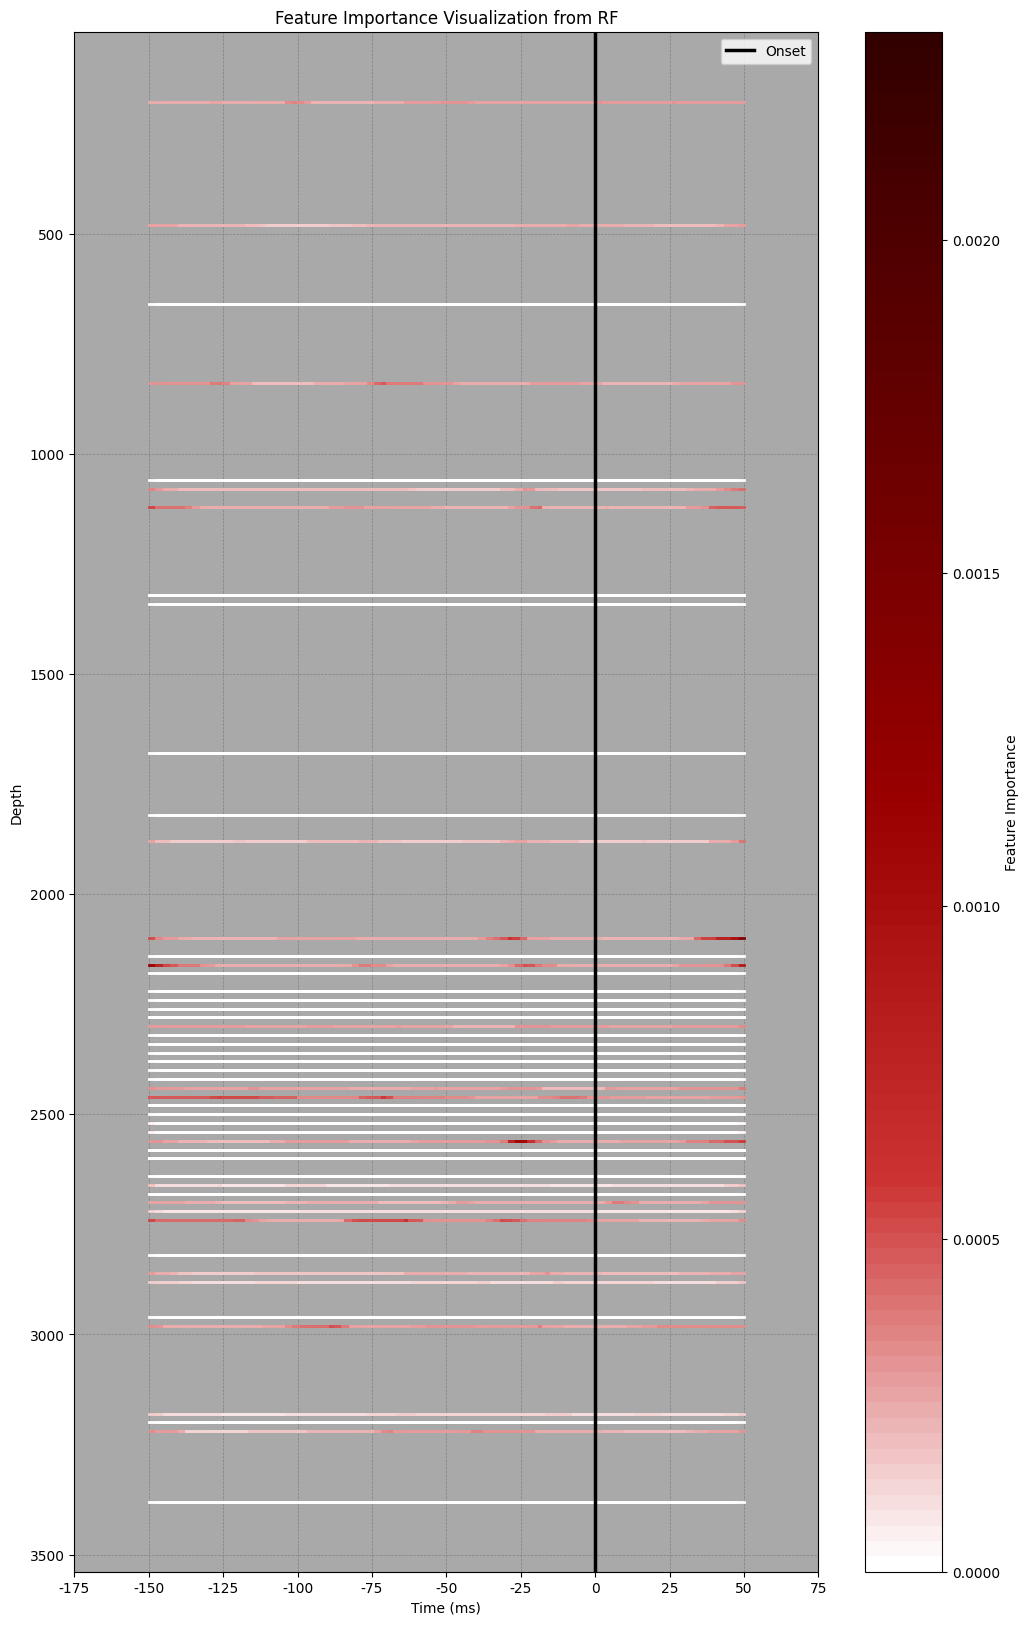

In [ ]:
norm = mcolors.Normalize(vmin=feature_importances['Importance'].min(), vmax=feature_importances['Importance'].max())

# Create a custom colormap from white to dark dark red
colors = [(1, 1, 1), (0.8, 0.2, 0.2), (0.6, 0, 0), (0.4, 0, 0), (0.2, 0, 0)]  # RGB for white to dark dark red
n_bins = 100  # Discretize the colormap into 100 bins
cmap_name = 'white_to_dark_dark_red'
cm = mcolors.LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

# Plotting
plt.figure(figsize=(12, 20))
plt.gca().set_facecolor('darkgrey')  # Set background to dark grey

for _, row in feature_importances.iterrows():
    x_start = row['x']
    x_end = x_start + 400  # 20ms later, which is 400 samples
    y = row['y']
    importance = row['Importance']
    color = cm(norm(importance))
    linewidth = max(importance * 8, 2)  # Increase the line width for better visibility

    plt.plot([x_start, x_end], [y, y], linewidth=linewidth, color=color, alpha=1.0)  # Higher alpha for better visibility

# Add a color bar to show the importance levels
sm = plt.cm.ScalarMappable(cmap=cm, norm=norm)
sm.set_array([])  # Only needed for matplotlib < 3.1
plt.colorbar(sm, ax=plt.gca(), label='Feature Importance')

# Add a bold vertical line at x=0 for onset
plt.axvline(x=0, color='black', linestyle='-', linewidth=2.5, label='Onset')

plt.xlabel('Time (ms)')
plt.ylabel('Depth')
plt.gca().invert_yaxis()  # Invert y-axis to have smallest depth on top
plt.title('Feature Importance Visualization from RF')
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')

# Adjust x-axis labels to be divided by 20
xticks = plt.gca().get_xticks()
plt.gca().set_xticks(xticks)
plt.gca().set_xticklabels([f'{int(x/20)}' for x in xticks])

# Add legend for the onset line
plt.legend()

plt.show()

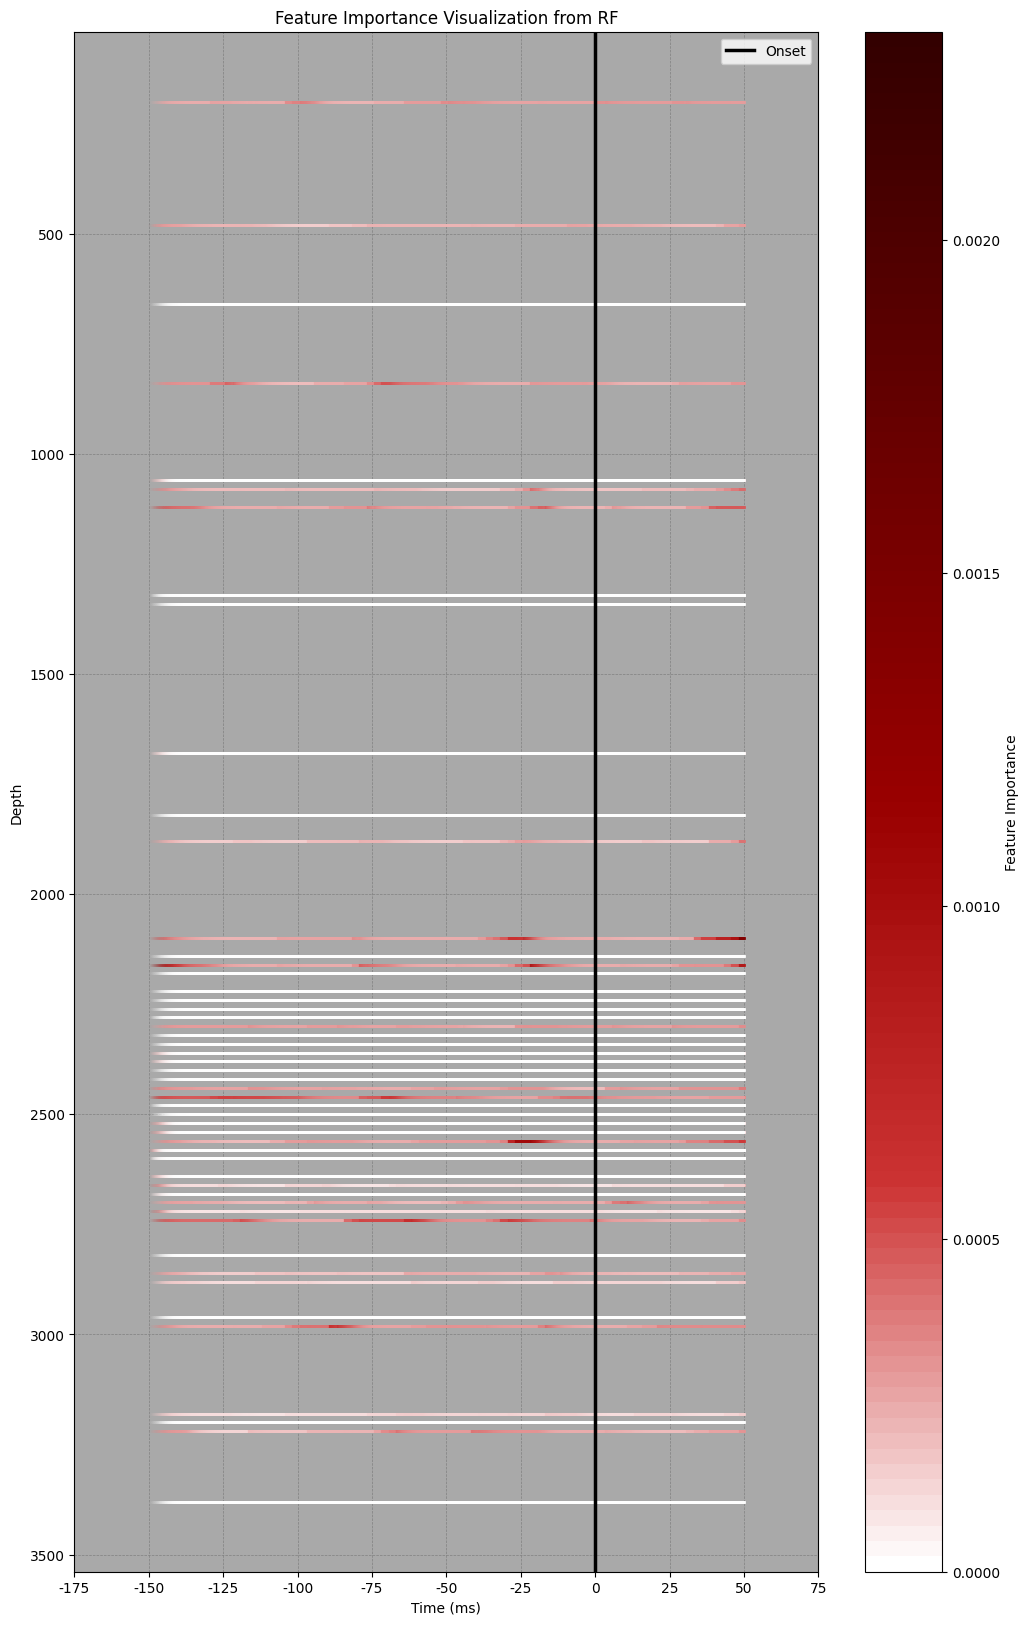

In [ ]:
norm = mcolors.Normalize(vmin=feature_importances['Importance'].min(), vmax=feature_importances['Importance'].max())

# Create a custom colormap from white to dark dark red
colors = [(1, 1, 1), (0.8, 0.2, 0.2), (0.6, 0, 0), (0.4, 0, 0), (0.2, 0, 0)]  # RGB for white to dark dark red
n_bins = 100  # Discretize the colormap into 100 bins
cmap_name = 'white_to_dark_dark_red'
cm = mcolors.LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

# Function to create a fading line
def fading_line(ax, x_start, x_end, y, color, linewidth):
    n = 100  # Number of points for the gradient effect
    x = np.linspace(x_start, x_end, n)
    y = np.full_like(x, y)
    for i in range(n-1):
        alpha = i / (n-1)
        ax.plot(x[i:i+2], y[i:i+2], color=color, linewidth=linewidth, alpha=alpha)

# Plotting
fig, ax = plt.subplots(figsize=(12, 20))
ax.set_facecolor('darkgrey')  # Set background to dark grey

for _, row in feature_importances.iterrows():
    x_start = row['x']
    x_end = x_start + 400  # 20ms later, which is 400 samples
    y = row['y']
    importance = row['Importance']
    color = cm(norm(importance))
    linewidth = max(importance * 8, 2)  # Increase the line width for better visibility

    fading_line(ax, x_start, x_end, y, color, linewidth)

# Add a color bar to show the importance levels
sm = plt.cm.ScalarMappable(cmap=cm, norm=norm)
sm.set_array([])  # Only needed for matplotlib < 3.1
plt.colorbar(sm, ax=ax, label='Feature Importance')

# Add a bold vertical line at x=0 for onset
plt.axvline(x=0, color='black', linestyle='-', linewidth=2.5, label='Onset')

plt.xlabel('Time (ms)')
plt.ylabel('Depth')
plt.gca().invert_yaxis()  # Invert y-axis to have smallest depth on top
plt.title('Feature Importance Visualization from RF')
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')

# Adjust x-axis labels to be divided by 20
xticks = plt.gca().get_xticks()
plt.gca().set_xticks(xticks)
plt.gca().set_xticklabels([f'{int(x/20)}' for x in xticks])

# Add legend for the onset line
plt.legend()

plt.show()

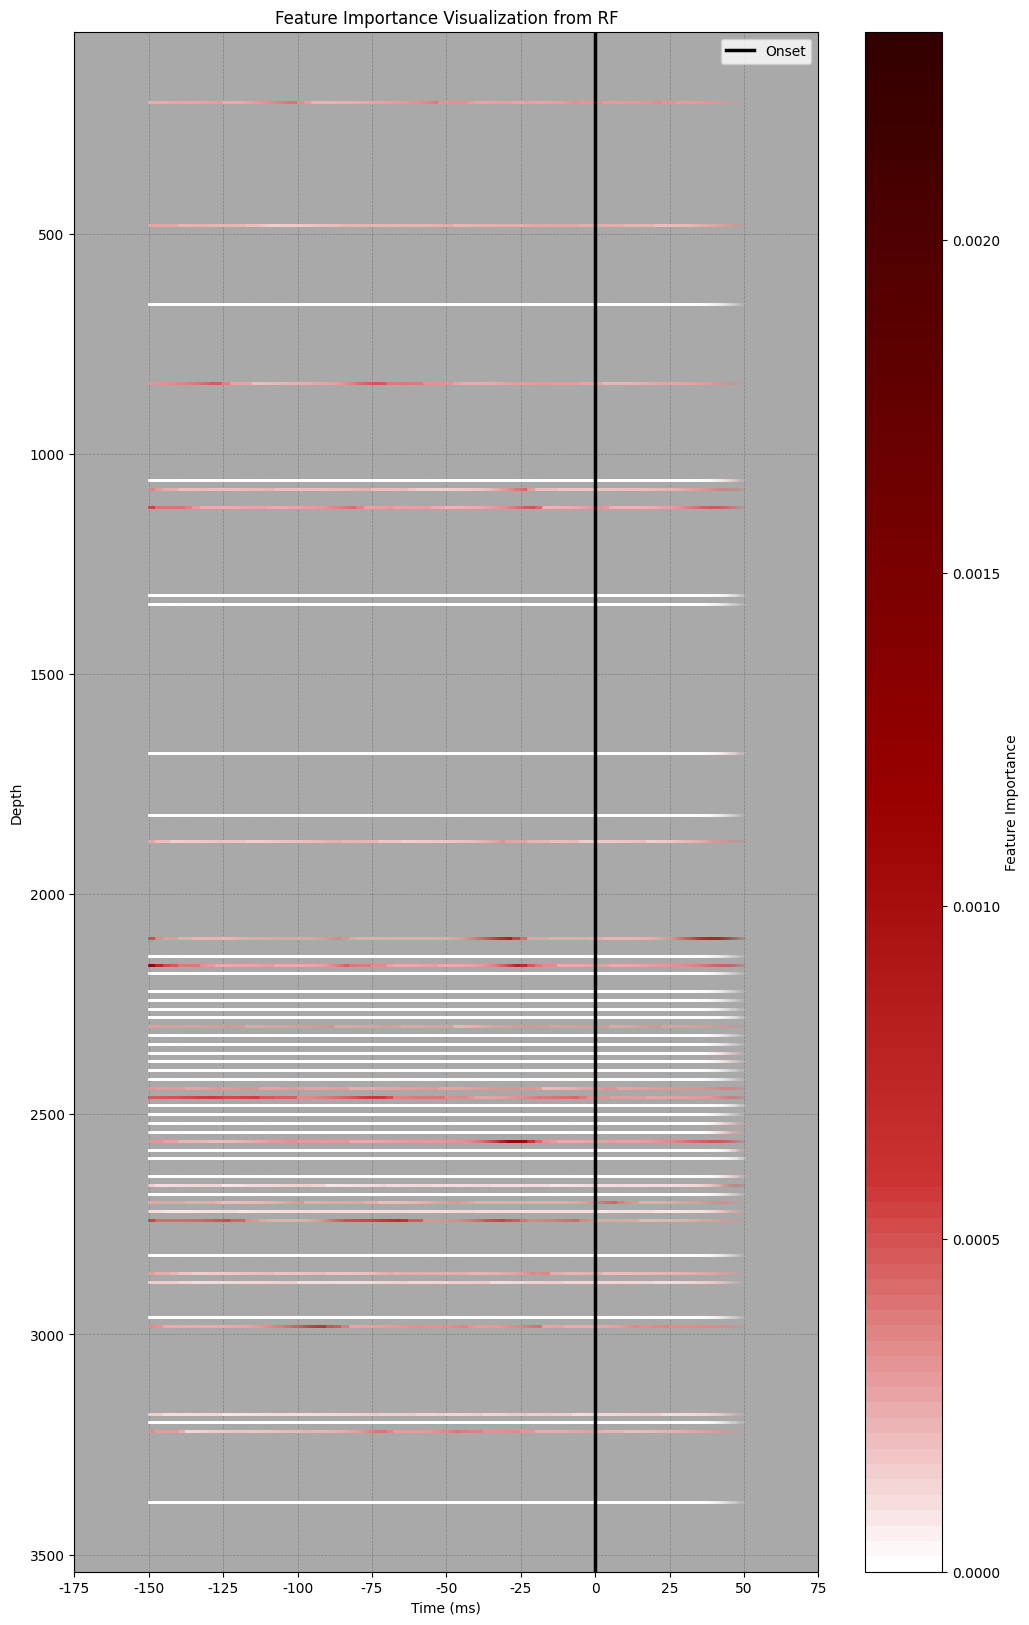

In [ ]:
norm = mcolors.Normalize(vmin=feature_importances['Importance'].min(), vmax=feature_importances['Importance'].max())

# Create a custom colormap from white to dark dark red
colors = [(1, 1, 1), (0.8, 0.2, 0.2), (0.6, 0, 0), (0.4, 0, 0), (0.2, 0, 0)]  # RGB for white to dark dark red
n_bins = 100  # Discretize the colormap into 100 bins
cmap_name = 'white_to_dark_dark_red'
cm = mcolors.LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

# Function to create a fading line with exponential decay
def fading_line(ax, x_start, x_end, y, color, linewidth):
    n = 100  # Number of points for the gradient effect
    x = np.linspace(x_start, x_end, n)
    y = np.full_like(x, y)
    for i in range(n-1):
        alpha = np.exp(-3 * i / (n-1))  # Exponential decay
        ax.plot(x[i:i+2], y[i:i+2], color=color, linewidth=linewidth, alpha=alpha)

# Plotting
fig, ax = plt.subplots(figsize=(12, 20))
ax.set_facecolor('darkgrey')  # Set background to dark grey

for _, row in feature_importances.iterrows():
    x_start = row['x']
    x_end = x_start + 400  # 20ms later, which is 400 samples
    y = row['y']
    importance = row['Importance']
    color = cm(norm(importance))
    linewidth = max(importance * 8, 2)  # Increase the line width for better visibility

    fading_line(ax, x_start, x_end, y, color, linewidth)

# Add a color bar to show the importance levels
sm = plt.cm.ScalarMappable(cmap=cm, norm=norm)
sm.set_array([])  # Only needed for matplotlib < 3.1
plt.colorbar(sm, ax=ax, label='Feature Importance')

# Add a bold vertical line at x=0 for onset
plt.axvline(x=0, color='black', linestyle='-', linewidth=2.5, label='Onset')

plt.xlabel('Time (ms)')
plt.ylabel('Depth')
plt.gca().invert_yaxis()  # Invert y-axis to have smallest depth on top
plt.title('Feature Importance Visualization from RF')
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')

# Adjust x-axis labels to be divided by 20
xticks = plt.gca().get_xticks()
plt.gca().set_xticks(xticks)
plt.gca().set_xticklabels([f'{int(x/20)}' for x in xticks])

# Add legend for the onset line
plt.legend()

plt.show()

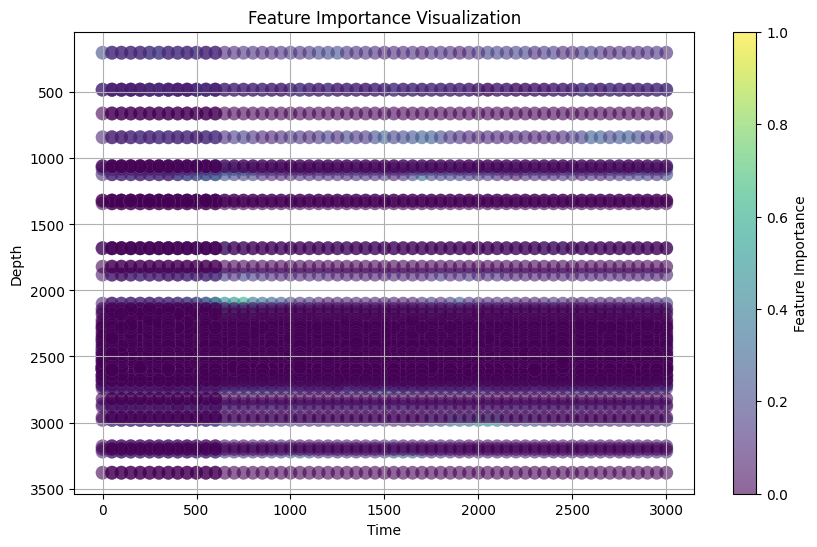

In [ ]:
# norm = mcolors.Normalize(vmin=feature_importances['Importance'].min(), vmax=feature_importances['Importance'].max())
# colors = plt.cm.viridis(norm(feature_importances['Importance']))

# # Plotting
# plt.figure(figsize=(10, 6))
# plt.scatter(feature_importances['x'], feature_importances['y'], s=100, c=colors, alpha=0.6, edgecolors="w", linewidth=0.05)
# plt.colorbar(label='Feature Importance')
# plt.xlabel('Time')
# plt.ylabel('Depth')
# plt.gca().invert_yaxis()  # Invert y-axis to have smallest depth on top
# plt.title('Feature Importance Visualization')
# plt.grid(True)
# plt.show()

In [ ]:
feature_importances

,Importance,Depth
24,0.044836,2520
26,0.043221,2540
20,0.042568,2460
46,0.040054,2660
19,0.034640,2440
...,...,...
31,0.000000,2600
32,0.000000,2600
36,0.000000,2640
1,0.000000,1320


# Clustering on data

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

kmeans = KMeans(n_clusters=7)
kmeans.fit(X_scaled)
clusters = kmeans.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
ari = adjusted_rand_score(y, clusters)
mi = mutual_info_score(y, clusters)

print(f"Adjusted Rand Index: {ari}")
print(f"Mutual Information: {mi}")

Adjusted Rand Index: 0.03036434922956604
Mutual Information: 0.12015707728545173


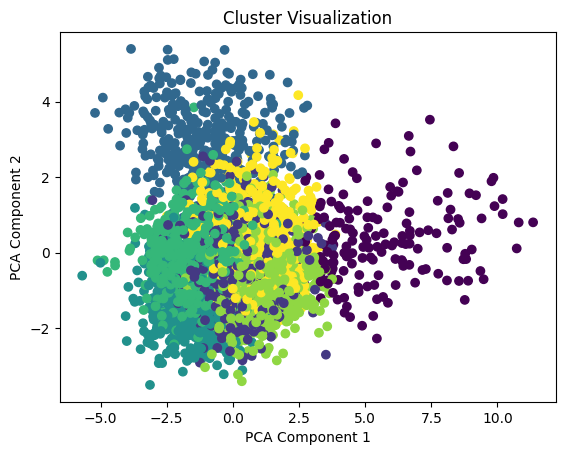

In [ ]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis')
plt.title("Cluster Visualization")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

# Clustering on Normalized data

# Clustering without PCA

In [ ]:
kmeans = KMeans(n_clusters=7)
clusters = kmeans.fit_predict(X)
silhouette_avg = silhouette_score(X, clusters)
print(f"Silhouette Score: {silhouette_avg:.2f}")
adjusted_rand = adjusted_rand_score(y, clusters)
print(f"Adjusted Rand Index: {adjusted_rand:.2f}")

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score: 0.09
Adjusted Rand Index: 0.02


# Learning Curve

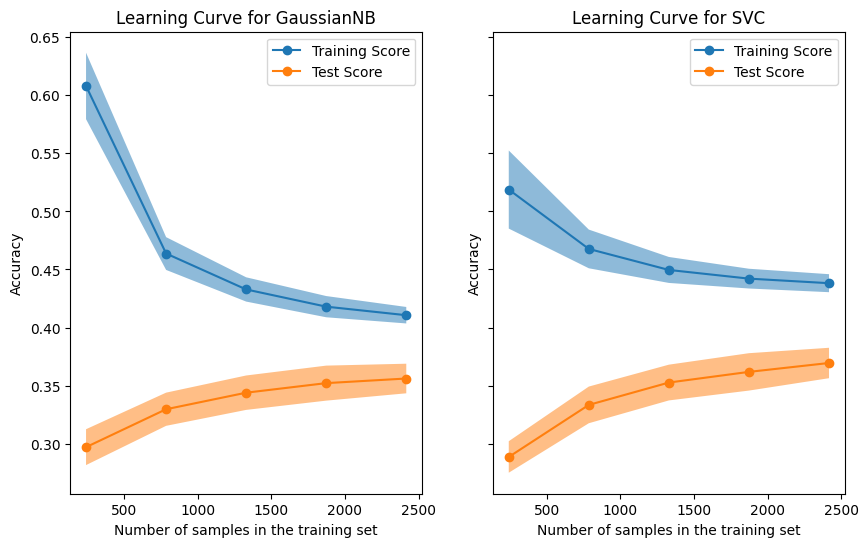

In [ ]:
naive_bayes = GaussianNB()
svc = SVC(kernel="rbf", C=10, gamma='scale')

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 6), sharey=True)

common_params = {
    "X": X,
    "y": y,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=50, test_size=0.3, random_state=0),
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
}

for ax_idx, estimator in enumerate([naive_bayes, svc]):
    LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax[ax_idx])
    handles, label = ax[ax_idx].get_legend_handles_labels()
    ax[ax_idx].legend(handles[:2], ["Training Score", "Test Score"])
    ax[ax_idx].set_title(f"Learning Curve for {estimator.__class__.__name__}")

plt.show()


In [ ]:
naive_bayes = GaussianNB()
# svc = SVC(kernel="rbf") # C: 1, gamma: scaled
svc = SVC(kernel="linear") # C: 1, gamma: scaled

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 6), sharey=True)

common_params = {
    "X": X_N,
    "y": y,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=50, test_size=0.3, random_state=0),
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
}

for ax_idx, estimator in enumerate([naive_bayes, svc]):
    LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax[ax_idx])
    handles, label = ax[ax_idx].get_legend_handles_labels()
    ax[ax_idx].legend(handles[:2], ["Training Score", "Test Score"])
    ax[ax_idx].set_title(f"Learning Curve for {estimator.__class__.__name__}")

plt.show()